# Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from scipy.stats import gaussian_kde

# Parameter Estimation Using Metropolis-Hastings MCMC

## Introduction
We address the non-linear inverse problem of estimating the parameters of a model given by the equation $ G(m_i) = m_1 e^{m_2 x_i} + m_3 x_i e^{m_4 x_i} $, using synthetic data sets generated through a stochastic algorithm.

## Problem Formulation
Given a set of observations $ \mathbf{d} $ with known independent Gaussian noise, we aim to estimate the model parameters $ \mathbf{m} = \{m_1, m_2, m_3, m_4\} $. The likelihood function is given by
$$
f(\mathbf{d} | \mathbf{m}) \propto \exp \left( -\frac{1}{2} \sum_{i=1}^{m} \left( \frac{d_i - G(m_i)}{\sigma_i} \right)^2 \right),
$$
where $ \sigma_i $ is the standard deviation of the noise.

## Metropolis-Hastings Algorithm
To sample from the posterior distribution $ p(\mathbf{m} | \mathbf{d}) $, we implemented the Metropolis-Hastings algorithm. Starting with an initial guess for the parameters, the algorithm proceeds as follows:
1. Generate a proposal $ \mathbf{m'} $ by perturbing the current parameters $ \mathbf{m} $ with a Gaussian distribution.
2. Calculate the likelihood ratio of the proposal to the current parameters.
3. Accept or reject the proposal based on the likelihood ratio and a random threshold.

## Implementation
The Python code provided implements the Metropolis-Hastings algorithm. The initial parameters and proposal standard deviations were carefully chosen based on the bounds of the parameters and the scale of the problem.

### Optimization Techniques
Several optimization techniques were employed in the code:
- **Proposal Distribution:** The standard deviations for the proposal distribution were set to $0.005$, ensuring that the proposals are neither too aggressive nor too conservative.
- **Prior Bounds:** Uniform priors were used for the parameters within reasonable bounds based on the problem context.
- **Warm-up and Thinning:** To reduce autocorrelation in the samples, a warm-up period was used, and samples were thinned by taking every 10,000th sample after warm-up.

### Autocorrelation Reduction
Autocorrelation was assessed by plotting the autocorrelation function for each parameter up to a lag of 50. This was used to determine the effective sample size and to confirm that the thinning interval was sufficient to produce effectively uncorrelated samples.

## Results
The algorithm successfully estimated the parameters of the model. The Maximum A Posteriori (MAP) estimate provided a point estimate for the parameters, while the posterior samples allowed for the estimation of credible intervals.

### Figures
Figures illustrating the autocorrelation and the sampled posterior distribution are provided in the Python code.

## Conclusion
The Metropolis-Hastings MCMC algorithm provides a robust method for parameter estimation in complex models. The code, along with the optimization techniques employed, demonstrate an effective approach to solving the inverse problem.


100%|██████████| 4100000/4100000 [05:09<00:00, 13229.14it/s]


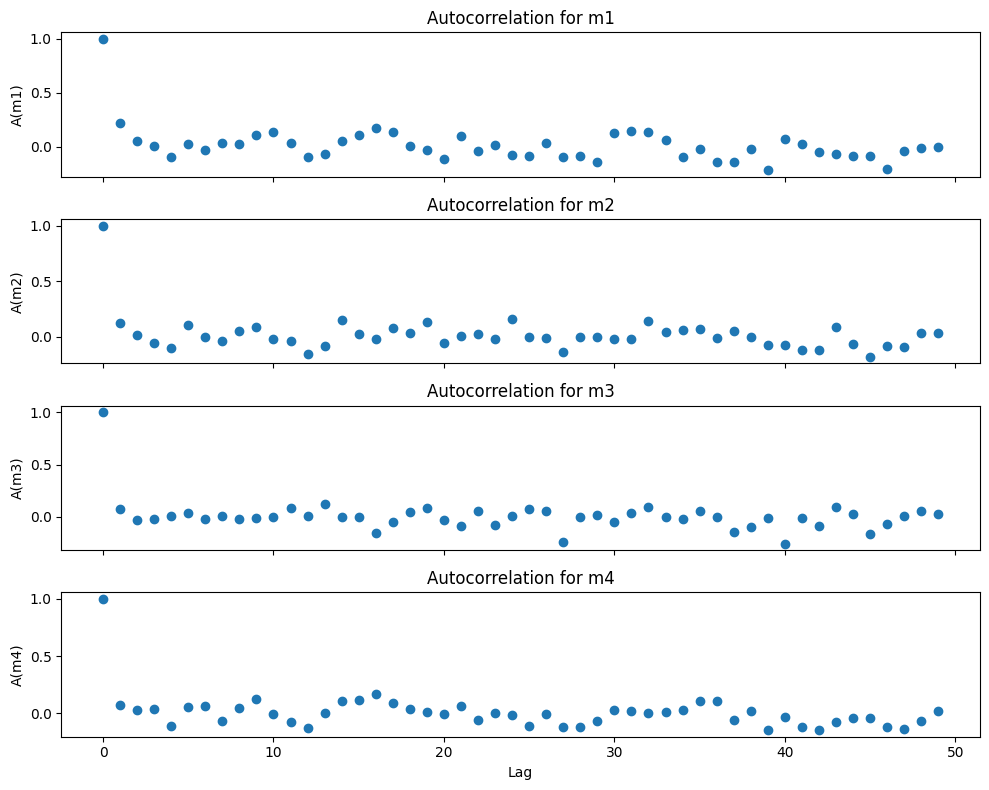

In [1]:
# Log-likelihood function
def log_likelihood(params, x, y, sigma):
    """
    Calculate the log-likelihood of the data given a set of model parameters.
    
    Parameters:
    - params (array): An array of parameters for the model.
    - x (array): The independent variable data points.
    - y (array): The dependent variable data points.
    - sigma (float): The standard deviation of the observational noise.
    
    Returns:
    - float: The log-likelihood of the data under the given model parameters.
    """
    model = params[0] * np.exp(params[1] * x) + params[2] * x * np.exp(params[3] * x)
    return -0.5 * np.sum(((y - model) / sigma)**2)

# Metropolis-Hastings MCMC function
def metropolis_hastings(initial_params, proposal_std, prior_bounds, iterations, data_x, data_y, sigma):
    """
    Perform the Metropolis-Hastings MCMC algorithm to sample from the posterior distribution of parameters.
    
    Parameters:
    - initial_params (array): An array of initial values for the model parameters.
    - proposal_std (array): Standard deviations for the proposal distribution.
    - prior_bounds (array): Bounds for the uniform prior distributions for each parameter.
    - iterations (int): The number of iterations to run the MCMC algorithm.
    - data_x (array): The independent variable data points.
    - data_y (array): The dependent variable data points.
    - sigma (float): The standard deviation of the observational noise.
    
    Returns:
    - tuple: A tuple containing arrays of accepted and rejected samples, and the MAP estimate of the model parameters.
    """
    current_params = initial_params
    accepted = []
    rejected = []
    for _ in tqdm(range(iterations)):
        proposal_params = np.random.normal(current_params, proposal_std)

        if np.all(proposal_params > prior_bounds[:, 0]) and np.all(proposal_params < prior_bounds[:, 1]):
            current_likelihood = log_likelihood(current_params, data_x, data_y, sigma)
            proposal_likelihood = log_likelihood(proposal_params, data_x, data_y, sigma)
            likelihood_ratio = proposal_likelihood - current_likelihood
            # Accept or reject the proposed parameters based on the likelihood ratio.
            if likelihood_ratio > np.log(np.random.rand()):
                accepted.append(proposal_params)
                current_params = proposal_params
            else:
                rejected.append(proposal_params)
        else:
            rejected.append(proposal_params)


# Autocorrelation function
def autocorrelation(chain, lag):
    """
    Compute the autocorrelation of a parameter sample chain at a given lag.
    
    Parameters:
    - chain (array): The parameter sample chain.
    - lag (int): The lag at which to compute the autocorrelation.
    
    Returns:
    - float: The autocorrelation at the specified lag.
    """
    n = len(chain)
    mean = np.mean(chain)
    var = np.var(chain)
    total = 0.0
    for i in range(n - lag):
        total += (chain[i] - mean) * (chain[i + lag] - mean)
    return total / ((n - lag) * var)

# Parameters
true_params = np.array([1.0, -0.5, 1.0, -0.75])
n_points = 25
x_data = np.linspace(1, 7, n_points)
noise_std = 0.01
y_observed = true_params[0] * np.exp(true_params[1] * x_data) + true_params[2] * x_data * np.exp(true_params[3] * x_data) + np.random.normal(0, noise_std, n_points)
initial_params = np.array([1, -1, 1, -1])
proposal_std = np.array([0.005, 0.005, 0.005, 0.005])
prior_bounds = np.array([[0, 2], [-1, 0], [0, 2], [-1, 0]])
iterations = 4100000

accepted, rejected, map_estimate = metropolis_hastings(initial_params, proposal_std, prior_bounds, iterations, x_data, y_observed, noise_std)

# Warm-up and thinning
warmup = 100000
thinning = 10000
accepted_thinned = accepted[warmup::thinning]

# Calculating autocorrelations for each parameter
lags = np.arange(50)
autocorr_params = np.zeros((4, len(lags)))
for i in range(4):
    for lag in lags:
        autocorr_params[i, lag] = autocorrelation(accepted_thinned[:, i], lag)

# Plot autocorrelation for each parameter
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
param_names = ['m1', 'm2', 'm3', 'm4']
for i in range(4):
    axs[i].plot(lags, autocorr_params[i, :], marker='o', linestyle='None')
    axs[i].set_ylabel(f'A({param_names[i]})')
    axs[i].set_title(f'Autocorrelation for {param_names[i]}')
axs[-1].set_xlabel('Lag')

plt.tight_layout()
plt.show()

In [2]:
print(map_estimate)

[ 0.99359836 -0.50533089  1.00907847 -0.74907955]


## Autocorrelation Plot Function

The `plot_autocorrelation_full` function visualizes the autocorrelation for each parameter in the MCMC chains before thinning. This function is essential for assessing the independence of samples within the chains, an important diagnostic in MCMC analysis.

### Function Definition

The function takes the following arguments:
- `chains`: A NumPy array containing the MCMC samples for parameters before thinning.
- `max_lag`: An integer specifying the maximum lag for which the autocorrelation is computed.
- `param_names`: A list of strings containing the names of the parameters for labeling the plots.
- `lag_step`: An integer that defines the step between consecutive lags for which the autocorrelation is computed.

### Computation and Plotting

For each parameter, the function computes the autocorrelation at intervals defined by `lag_step` up to `max_lag`. It then creates a series of subplots, each displaying the autocorrelation function for one parameter.


100%|██████████| 4/4 [03:14<00:00, 48.56s/it]


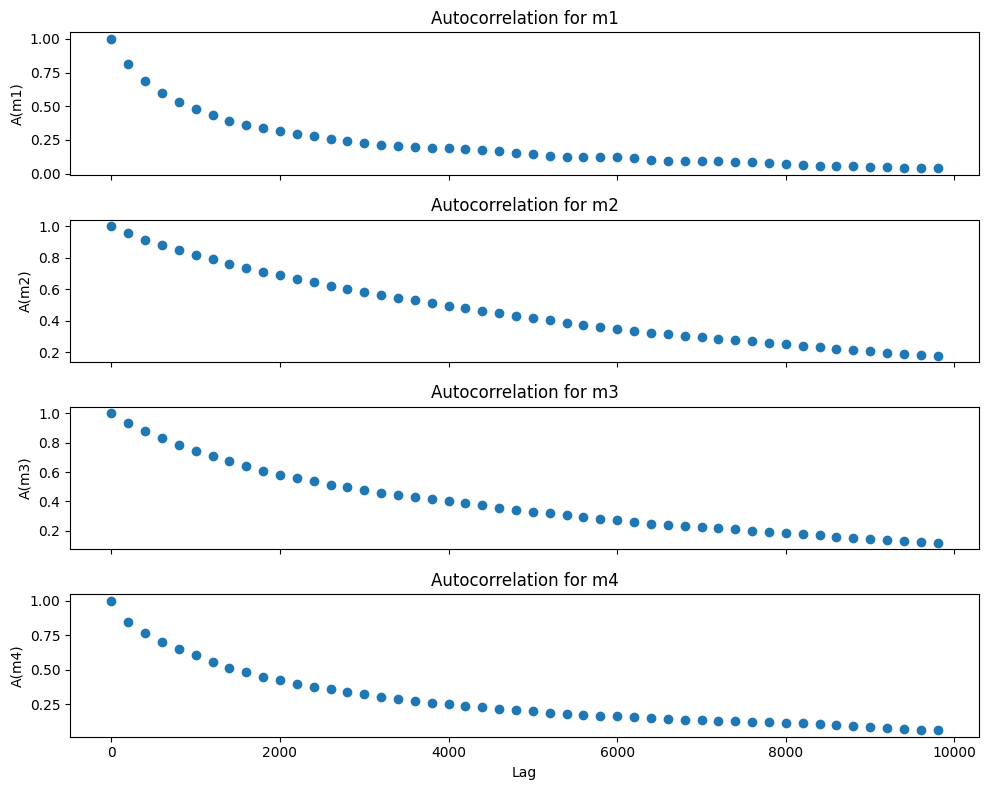

In [3]:
def plot_autocorrelation_full(chains, max_lag, param_names, lag_step):
    """
    Plots the autocorrelation for each parameter in the chains before thinning,
    sampling every 'lag_step' lags to reduce computation.

    Parameters:
    chains (np.array): MCMC samples for parameters before thinning.
    max_lag (int): The maximum lag to compute the autocorrelation.
    param_names (list): List of parameter names for labeling the plots.
    lag_step (int): The step between lags to compute the autocorrelation.
    """
    autocorr_params = np.zeros((len(param_names), max_lag // lag_step))
    for i in tqdm(range(len(param_names))):
        for j, lag in enumerate(tqdm(range(0, max_lag, lag_step))):
            autocorr_params[i, j] = autocorrelation(chains[:, i], lag)

    fig, axs = plt.subplots(len(param_names), 1, figsize=(10, 8), sharex=True)
    for i in range(len(param_names)):
        axs[i].plot(range(0, max_lag, lag_step), autocorr_params[i, :], marker='o', linestyle='None')
        axs[i].set_ylabel(f'A({param_names[i]})')
        axs[i].set_title(f'Autocorrelation for {param_names[i]}')
    axs[-1].set_xlabel('Lag')

    plt.tight_layout()
    plt.show()

# Compute autocorrelation every 200 lags
lag_step = 200  
max_lag = 10000
plot_autocorrelation_full(accepted, max_lag, param_names, lag_step)


## Corner Plot Visualization

The `corner_plot` function is designed to create a comprehensive visualization that illustrates the results of an MCMC sampling process. This type of plot is pivotal for examining the posterior distributions of parameters and their interdependencies.

### Function Overview

- The **diagonal** plots are histograms representing the marginal distributions of each parameter.
- The **lower off-diagonal** plots are scatter plots showing the joint distributions between pairs of parameters, useful for spotting correlations.
- The **upper off-diagonal** plots are hidden as they duplicate the information in the lower half.

### Parameters:
- `samples`: A 2D NumPy array with shape `(n_samples, n_params)` containing the sampled parameter values from MCMC.
- `true_params`: A list containing the true values of the parameters for reference.
- `map_estimate`: A list containing the Maximum A Posteriori (MAP) estimate of the parameters.

### Special Features:
- A dashed line marks the true value on the histograms.
- A dotted line marks the MAP estimate on the histograms.
- True parameter values are marked with a black dot (`'ko'`) on the scatter plots.
- MAP estimatesare marked with a red dot (`'ro'`) on the scatter plots.

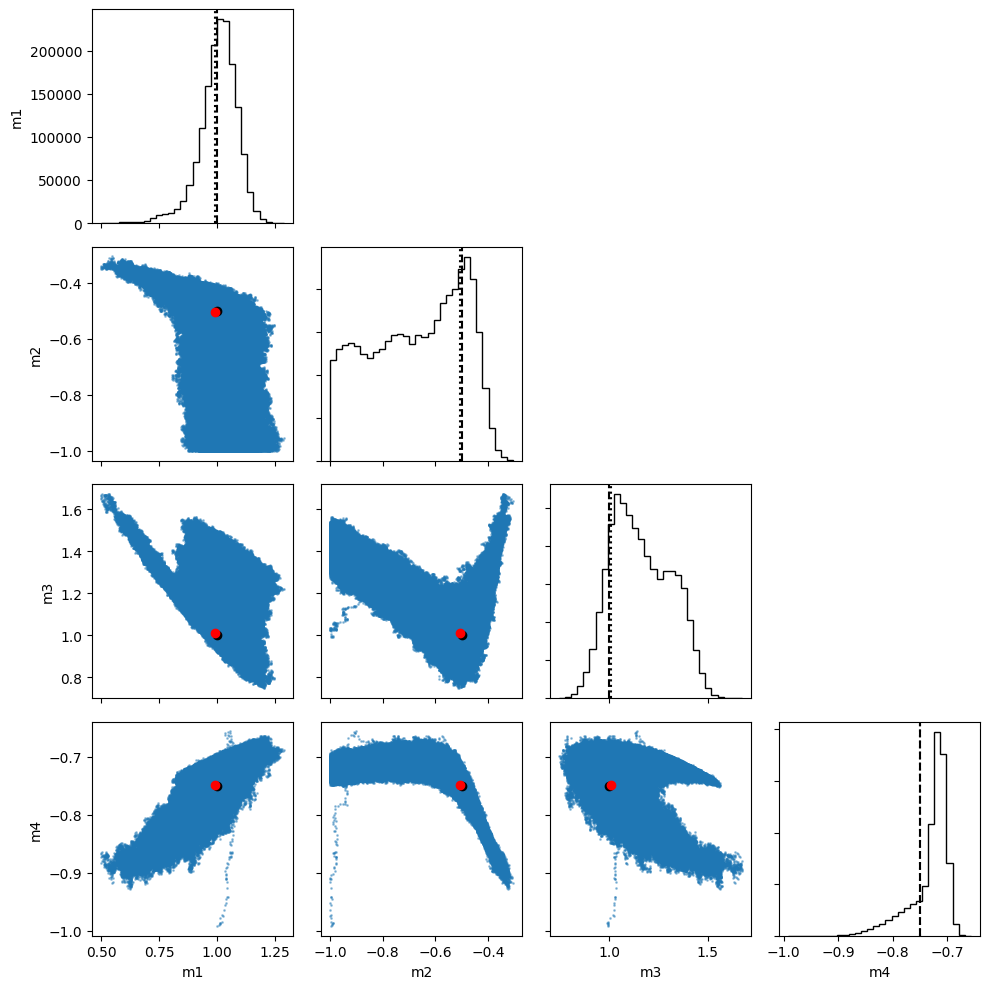

In [4]:
def corner_plot(samples, true_params=None, map_estimate=None):
    """
    Creates a corner plot with histograms on the diagonal and scatter plots off-diagonal.

    Parameters:
    samples (np.array): An array of shape (n_samples, n_params) containing MCMC samples.
    true_params (list): List containing the true parameter values.
    map_estimate (list): List containing the MAP estimate values.
    """
    n_params = samples.shape[1]
    fig, axes = plt.subplots(n_params, n_params, figsize=(10, 10))

    # Loop over all combinations of parameters for the lower triangle of the plot matrix
    for i in range(n_params):
        for j in range(n_params):
            ax = axes[i, j]
            if i == j:  # Diagonal: histograms
                ax.hist(samples[:, i], bins=30, color='black', histtype='step')
                if true_params is not None:
                    ax.axvline(true_params[i], color='k', linestyle='--')
                if map_estimate is not None:
                    ax.axvline(map_estimate[i], color='k', linestyle=':')
            elif i > j:  # Lower off-diagonal: scatter plots
                ax.scatter(samples[:, j], samples[:, i], s=1, alpha=0.4)
                if true_params is not None:
                    ax.plot(true_params[j], true_params[i], 'ko')
                if map_estimate is not None:
                    ax.plot(map_estimate[j], map_estimate[i], 'ro')
            else:
                ax.set_visible(False)

            if i == n_params - 1:
                ax.set_xlabel(f'm{j+1}')
            if j == 0:
                ax.set_ylabel(f'm{i+1}')

            if j > 0:
                ax.set_yticklabels([])
            if i < n_params - 1:
                ax.set_xticklabels([])

    plt.tight_layout()
    plt.show()

corner_plot(accepted, true_params=true_params, map_estimate=map_estimate)

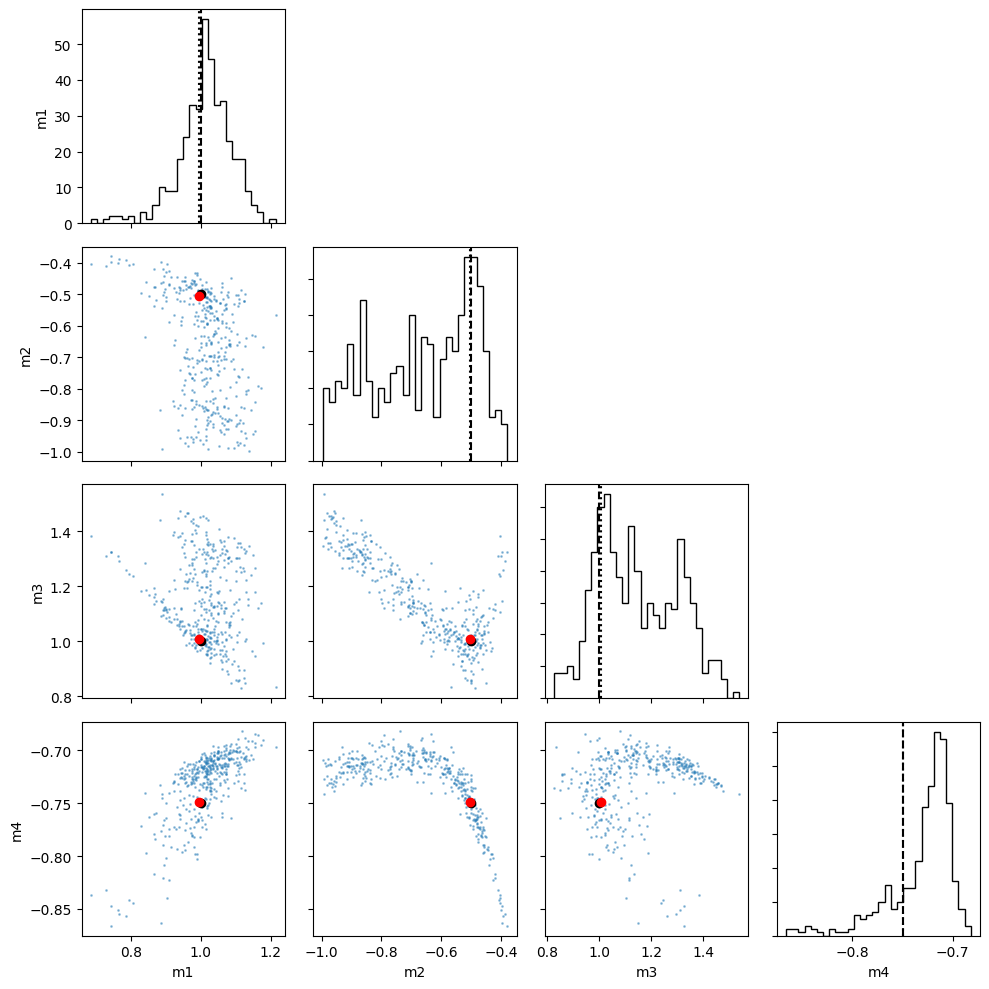

In [ ]:
num_samples = 400
if len(accepted) > num_samples:
    sample_indices = np.random.choice(len(accepted), num_samples, replace=False)
    sampled_accepted = accepted[sample_indices]
else:
    sampled_accepted = accepted

corner_plot(sampled_accepted, true_params=true_params, map_estimate=map_estimate)

## Using in-build corner library for making the corner plots

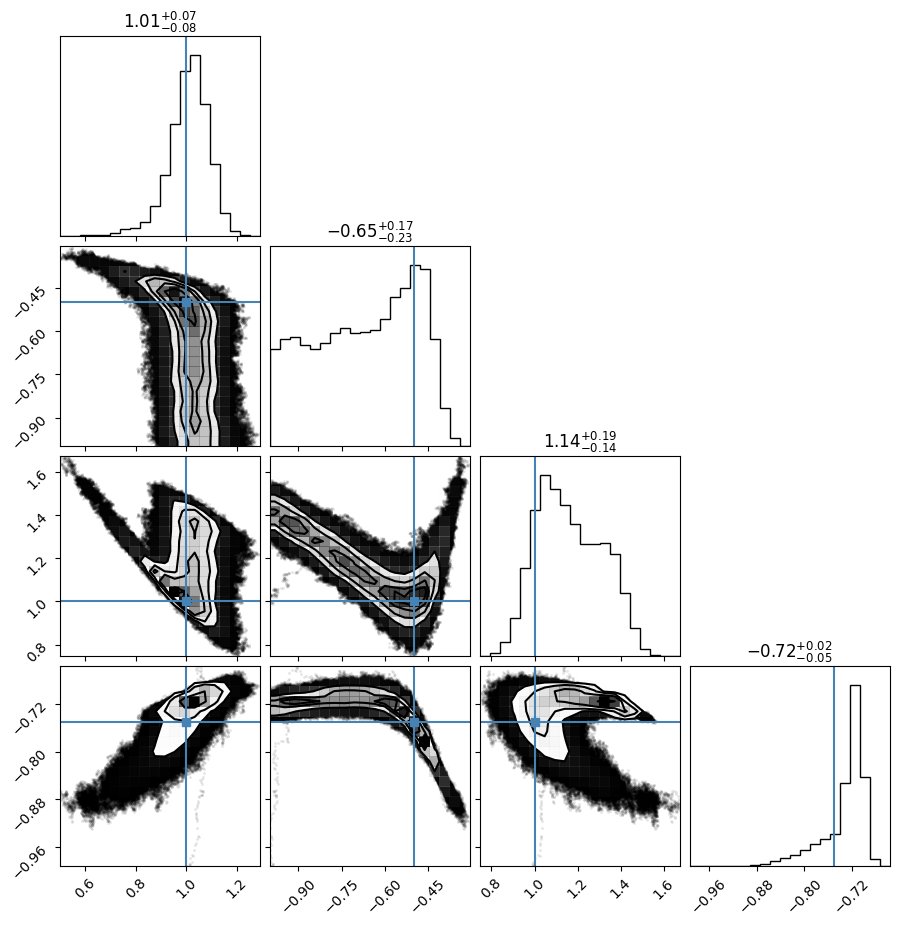

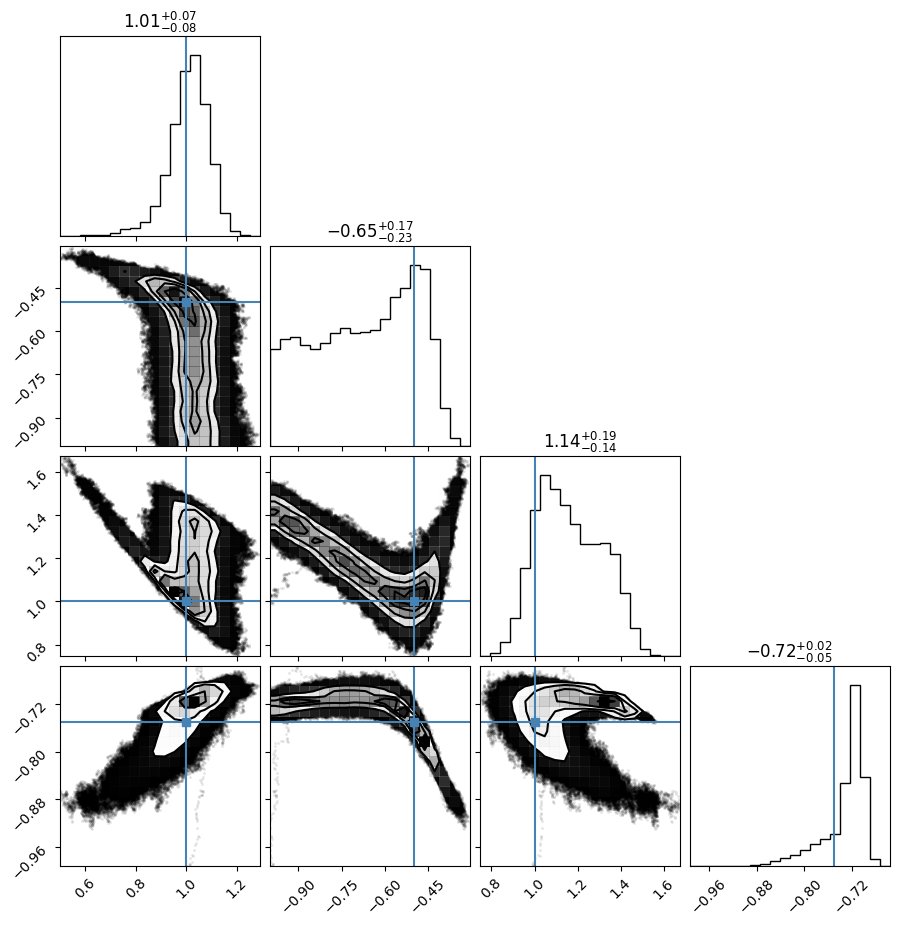

In [ ]:
!pip install corner

import corner
corner.corner(accepted, truths=true_params, show_titles=True)

## MCMC Trace Plot Function

The `plot_mcmc_trace` function visualizes the trace of MCMC samples for each parameter. Trace plots are essential for assessing the convergence of the MCMC chains. A well-mixed chain should display a 'fuzzy caterpillar' look, indicating a good exploration of the parameter space. This look is visible in the image figure formed below.

#### Parameters:
- `samples`: A 2D NumPy array of MCMC samples with shape `(n_samples, n_params)`.
- `true_params`: A list of the true parameter values used to generate synthetic data.
- `param_names`: A list containing the names of each parameter for labeling purposes.

#### Function Description:
For each parameter, the function plots the sequence of sample values, providing insight into how the samples evolve over the iterations. This is a critical step in diagnosing the performance of the MCMC sampler.

### Key Features:
- Each parameter has its own subplot for a clear, segmented view.
- The true parameter values are marked with a horizontal dashed line for reference.
- The `Sample Number` on the x-axis helps track the progression of the sampling process.

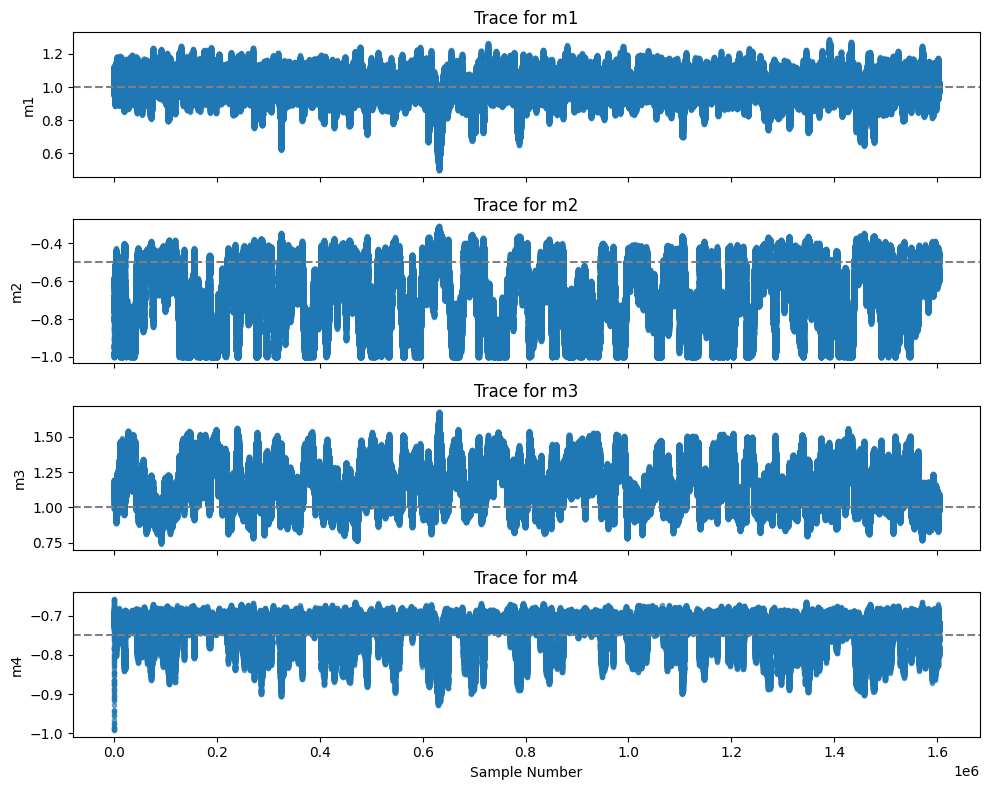

In [ ]:
def plot_mcmc_trace(samples, true_params, param_names):
    """
    Plot the MCMC trace posterior samples.

    Parameters:
    samples (np.array): MCMC samples, with shape (n_samples, n_params).
    true_params (list): True values for the parameters.
    param_names (list): Names of the parameters.
    """
    n_params = samples.shape[1]
    fig, axs = plt.subplots(n_params, 1, figsize=(10, 2 * n_params), sharex=True)

    for i in range(n_params):
        ax = axs[i]
        ax.plot(samples[:, i], 'o', markersize=3, alpha=0.6)
        ax.axhline(y=true_params[i], color='gray', linestyle='--')
        ax.set_ylabel(param_names[i])
        ax.set_title(f'Trace for {param_names[i]}')

    axs[-1].set_xlabel('Sample Number')

    plt.tight_layout()
    plt.show()

plot_mcmc_trace(accepted, true_params, param_names)


## Enhanced MCMC Trace Plot Function
The updated `plot_mcmc_trace` function now includes an additional parameter `num_samples`, which allows for a uniform sampling of trace points from the full set of MCMC samples. This enhancement is designed to provide a clearer visualization when dealing with large numbers of samples.

#### Additional Parameter:
- `num_samples`: Specifies how many uniformly spaced sample points should be plotted. This parameter is particularly useful when the total number of MCMC samples is very large, which can make the trace plots difficult to read due to overplotting.

#### Function Behavior:
- Instead of plotting every single sample, which can result in a dense and potentially confusing plot, the function now selects a uniform subset of `num_samples` points across the entire chain.
- This approach provides a more legible and informative visualization, especially when assessing the convergence and mixing of the chains.

### Comparison to Previous Function:
- The original function plotted all samples in the trace, which could lead to crowded plots with too many overlapping points.
- The new function selectively plots a subset of the data, providing a clearer view of the trace without losing the overall pattern and trends.

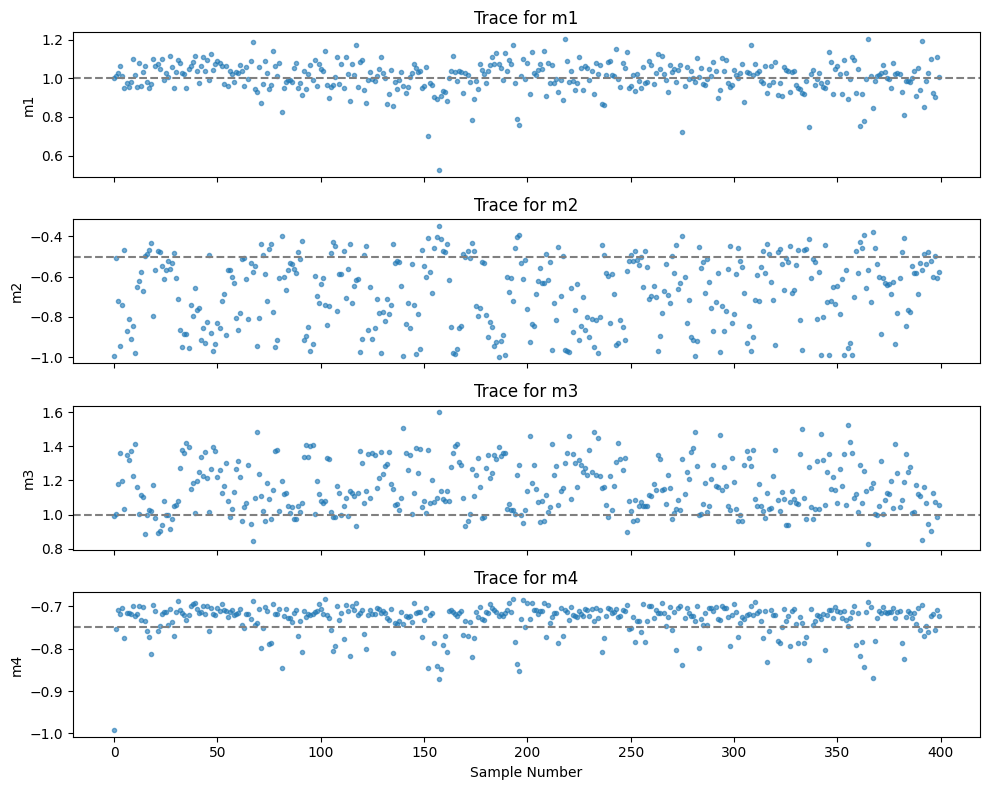

In [ ]:
def plot_mcmc_trace(samples, true_params, param_names, num_samples=400):
    """
    Plot the MCMC trace for uniformly sampled posterior points.

    Parameters:
    samples (np.array): MCMC samples, with shape (n_samples, n_params).
    true_params (list): True values for the parameters.
    param_names (list): Names of the parameters.
    num_samples (int): Number of uniformly sampled points to plot.
    """
    n_params = samples.shape[1]

    # Uniformly sample points
    indices = np.linspace(0, len(samples)-1, num_samples, dtype=int)
    sampled_points = samples[indices]

    fig, axs = plt.subplots(n_params, 1, figsize=(10, 2 * n_params), sharex=True)

    for i in range(n_params):
        ax = axs[i]
        ax.plot(sampled_points[:, i], 'o', markersize=3, alpha=0.6)
        ax.axhline(y=true_params[i], color='gray', linestyle='--')
        ax.set_ylabel(param_names[i])
        ax.set_title(f'Trace for {param_names[i]}')

    axs[-1].set_xlabel('Sample Number')

    plt.tight_layout()
    plt.show()

num_samples = 400

plot_mcmc_trace(accepted, true_params, param_names, num_samples)

## plot for thinned accepted samples 

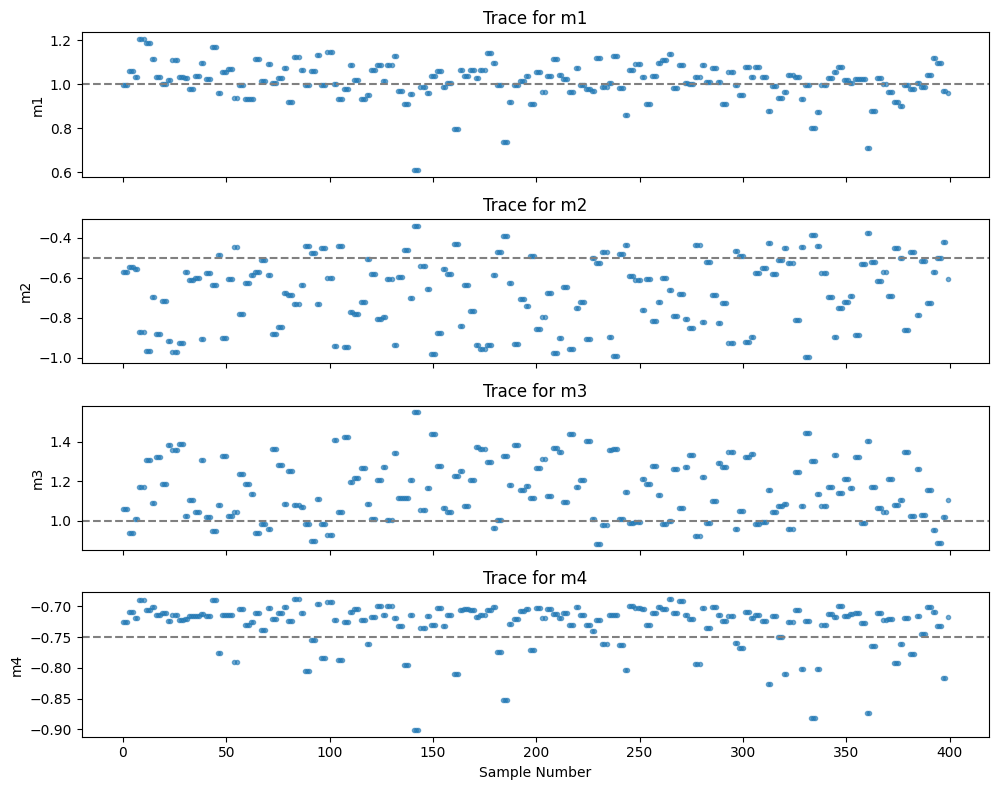

In [ ]:
plot_mcmc_trace(accepted_thinned, true_params, param_names, num_samples)

## How was the random proposal obtained and what optimization techinique did we use to arrive at suitable proposal generator

Normal distribution for the proposal distribution was chosen over other distribution because of its advantageous statistical properties that align well with the requirements of an efficient MCMC algorithm. Its symmetric nature is crucial in satisfying the detailed balance condition of the Metropolis-Hastings algorithm, ensuring equal probability for proposing moves to and from states in the parameter space. The central tendency of the normal distribution concentrates most proposals near the current state, which tends to increase the acceptance rate, an essential aspect of a well-performing MCMC chain. This central clustering, paired with the tunable variance, allows for a delicate balance between exploration and exploitation. By adjusting the standard deviation, the step size can be calibrated to navigate the posterior landscape effectively, avoiding both the pitfalls of local mode entrapment and inefficient random wandering.

Additionally, the mathematical tractability of the normal distribution, with its well-studied cumulative and probability density functions, simplifies both analytical solutions and computational sampling. This simplicity is a boon for both implementing the MCMC algorithm and for interpreting its results. Furthermore, when the likelihood is normally distributed, the normal proposal distribution can exploit conjugacy, leading to computational efficiencies. Its empirical success in diverse applications lends practical confidence, reinforcing its selection as the proposal distribution in my MCMC implementation. These were the reason behind the chocie of normal distribution for the proposal mechanism in sampling complex posterior distributions.



The standard deviation (denoted by σ_i) controls the step size. The choice of σ_i is a trade-off:

- **Smaller σ_i (Smaller Steps):**
  - **Pros:** Leads to a higher acceptance rate because the proposed steps are closer to the current position, making them more likely to be in a region of high posterior density.
  - **Cons:** Can result in slow exploration of the posterior distribution, as the Markov chain takes a long time to move across the parameter space, potentially requiring a larger number of iterations to adequately explore the distribution.

- **Larger σ_i (Larger Steps):**
  - **Pros:** Allows for faster exploration of the posterior distribution, which can be beneficial if the posterior is multimodal or spread out over a large range.
  - **Cons:** Can lead to a lower acceptance rate, as the proposed steps are often outside regions of high posterior density. This can result in the algorithm becoming stuck in a particular region, especially if that region is a local mode.

To arrive at a suitable proposal generator, we can use optimization techniques such as:

1. **Adaptive MCMC:**
   - Begin with a smaller σ_i and gradually increase it until an acceptable acceptance rate is achieved.
   - Or start with a larger σ_i and decrease it if the acceptance rate is too low.

2. **Tuning:**
   - Run preliminary MCMC simulations with different values of σ_i to find a range that offers a good balance between acceptance rate and state space exploration.
   - Use acceptance rates to tune σ_i, aiming for a rate typically between 20% to 50%.

3. **Heuristics:**
   - Use domain knowledge or empirical observations to inform the initial guess of σ_i.
   - For example, scale σ_i with the variance of the prior distribution or the scale of the data.


In this case, taking inspiration from "Parameter Estimation and Inverse Problems by Richard Aster" book we used σ_i = 0.05. From the results obtained it's evident that proposal distribution allowed the MCMC algorithm to efficiently explore the full breadth of the posterior distribution, providing a good approximation of the parameter estimates while maintaining computational tractability.